In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import copy
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets
from matplotlib.pyplot import imshow
from sklearn.metrics import f1_score
from torch.optim import SGD, Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [9]:
transform = transforms.Compose(
    [
        transforms.Resize(size=(180, 180)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dir = "../data/train"  # path to the train folder
validation_dir = "../data/validation"  # path to the validation folder
test_dir = "../data/test"  # path to test folder

train_data = datasets.ImageFolder(root=train_dir, transform=transform)

validation_data = datasets.ImageFolder(root=validation_dir, transform=transform)

test_data = datasets.ImageFolder(root=test_dir, transform=transform)

print(
    f"Train data:\n{train_data}\n\nValidation data:\n{validation_data}\n\nTest data:\n{test_data}"
)

data_loaders = {
    "train": DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2),
    "validation": DataLoader(
        validation_data, batch_size=4, shuffle=True, num_workers=2
    ),
}

Train data:
Dataset ImageFolder
    Number of datapoints: 3689
    Root location: ../data/train
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Validation data:
Dataset ImageFolder
    Number of datapoints: 495
    Root location: ../data/validation
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Test data:
Dataset ImageFolder
    Number of datapoints: 494
    Root location: ../data/test
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5,

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, dropout=0.4):  # Dodaj parametr dropout
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 22 * 22, 256)
        self.act4 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)  # Ustawienie dropout z parametru
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.pool1(self.act1(self.bn1(self.conv1(x))))
        out = self.pool2(self.act2(self.bn2(self.conv2(out))))
        out = self.pool3(self.act3(self.bn3(self.conv3(out))))
        out = out.view(out.size(0), -1)
        out = self.act4(self.fc1(out))
        out = self.dropout(out)  # Użycie dropout
        out = self.fc2(out)
        return out

In [11]:
class SimpleCNN_WithResidual(nn.Module):
    def __init__(self, num_classes=2, dropout=0.4):
        super(SimpleCNN_WithResidual, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 22 * 22, 256)
        self.act4 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        residual = x  # Save the input as residual
        out = self.pool1(self.act1(self.bn1(self.conv1(x))))
        out = self.pool2(self.act2(self.bn2(self.conv2(out))))
        out = self.pool3(self.act3(self.bn3(self.conv3(out))))

        # Add residual connection if dimensions match
        if residual.size() == out.size():
            out += residual

        out = out.view(out.size(0), -1)
        out = self.act4(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss, correct = 0, 0
    size = len(dataloader.dataset)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = 100 * correct / size
    return train_loss / len(dataloader), accuracy


def validate(dataloader, model, loss_fn):
    model.eval()
    validation_loss, correct = 0, 0
    size = len(dataloader.dataset)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = 100 * correct / size
    return validation_loss / len(dataloader), accuracy

In [13]:
loss_fn = nn.CrossEntropyLoss()
epochs = 20

In [14]:
models_to_compare = {
    "Base CNN": SimpleCNN(),
    "CNN with Residual Connection": SimpleCNN_WithResidual(),
}

results = {"model": [], "train_acc": [], "validation_acc": [], "train_loss": [], "validation_loss": [],}


for model_name, model_class in models_to_compare.items():

    print(f"Training {model_name}")

    model = model_class.to(device)

    optimizer = optim.SGD(model.parameters(), lr=1e-3)

    train_accuracies = []
    validation_accuracies = []
    train_losses = []
    validation_losses = []

    for epoch in range(epochs):

        print(f"Epoch {epoch+1}/{epochs}")

        train_loss, train_acc = train(data_loaders["train"], model, loss_fn, optimizer)

        val_loss, val_acc = validate(data_loaders["validation"], model, loss_fn)

        train_accuracies.append(train_acc)

        validation_accuracies.append(val_acc)

        train_losses.append(train_loss)
        validation_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")

    results["model"].append(model_name)

    results["train_acc"].append(train_accuracies[-1])

    results["validation_acc"].append(validation_accuracies[-1])

    results["train_loss"].append(train_losses[-1])
    results["validation_loss"].append(validation_losses[-1])

Training Base CNN
Epoch 1/20
Train Loss: 0.6111, Validation Loss: 0.5864
Train Accuracy: 69.23%, Validation Accuracy: 69.49%
Epoch 2/20
Train Loss: 0.5651, Validation Loss: 0.5855
Train Accuracy: 71.27%, Validation Accuracy: 69.49%
Epoch 3/20
Train Loss: 0.4896, Validation Loss: 0.4305
Train Accuracy: 76.06%, Validation Accuracy: 78.18%
Epoch 4/20
Train Loss: 0.3920, Validation Loss: 0.2993
Train Accuracy: 81.81%, Validation Accuracy: 89.90%
Epoch 5/20
Train Loss: 0.2960, Validation Loss: 0.2659
Train Accuracy: 87.02%, Validation Accuracy: 87.07%
Epoch 6/20
Train Loss: 0.2489, Validation Loss: 0.2134
Train Accuracy: 89.32%, Validation Accuracy: 91.31%
Epoch 7/20
Train Loss: 0.2149, Validation Loss: 0.2386
Train Accuracy: 90.95%, Validation Accuracy: 90.51%
Epoch 8/20
Train Loss: 0.1740, Validation Loss: 0.2002
Train Accuracy: 92.87%, Validation Accuracy: 91.52%
Epoch 9/20
Train Loss: 0.1575, Validation Loss: 0.2078
Train Accuracy: 93.22%, Validation Accuracy: 91.52%
Epoch 10/20
Train L

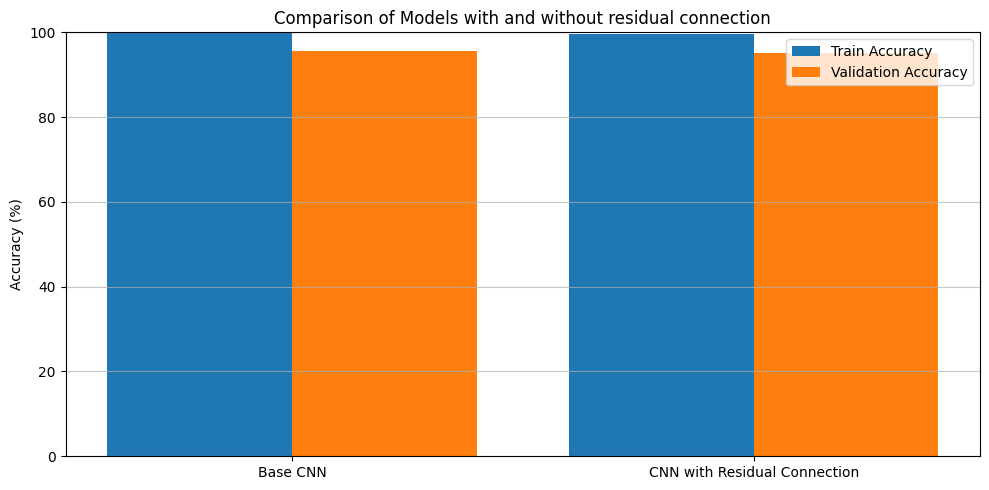

In [17]:
# Plot results
plt.figure(figsize=(10, 5))

x = range(len(results["model"]))
width = 0.4

# Train and Validation accuracy side by side for each optimizer
train_bar = plt.bar(
    [i - width / 2 for i in x],
    results["train_acc"],
    width=width,
    label="Train Accuracy",
)
val_bar = plt.bar(
    [i + width / 2 for i in x],
    results["validation_acc"],
    width=width,
    label="Validation Accuracy",
)

plt.xticks(x, results["model"])
plt.title("Comparison of Models with and without residual connection")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

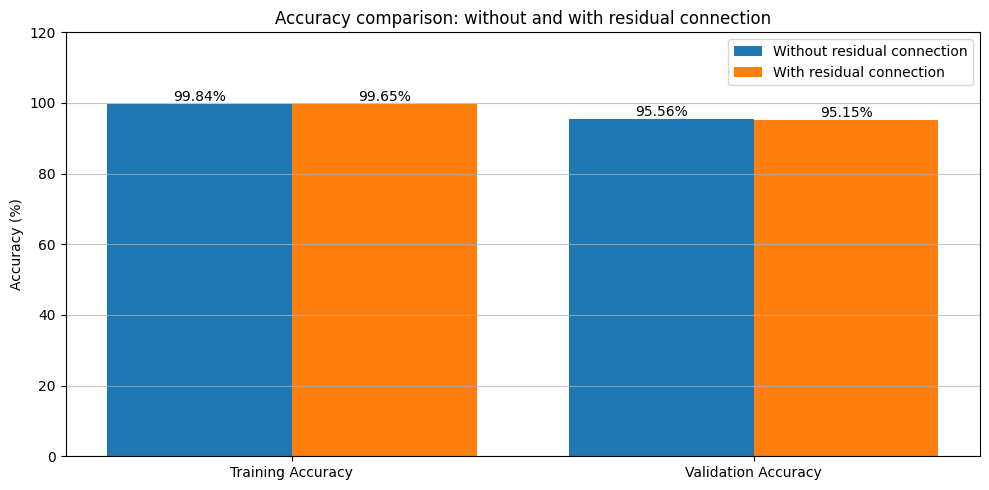

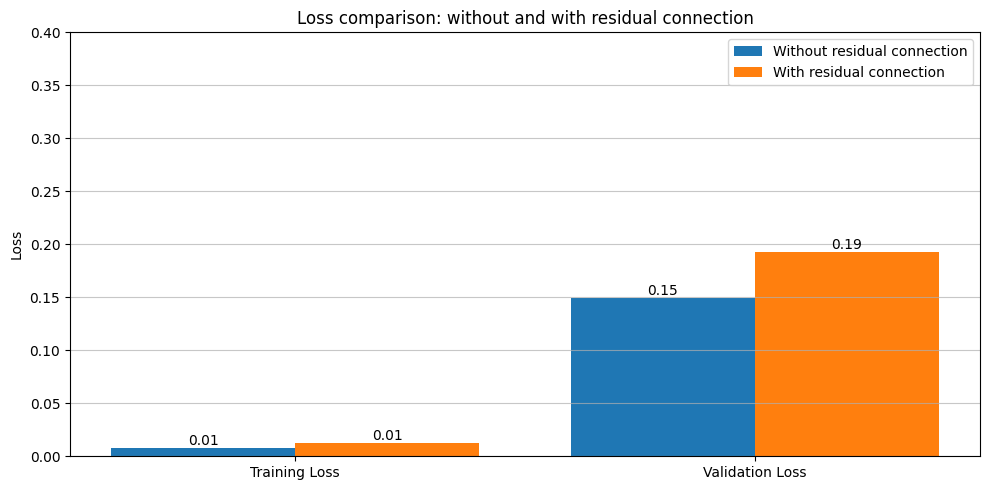

In [23]:
plt.figure(figsize=(10, 5))

x = range(len(results["model"]))
width = 0.4

# Train and Validation accuracy side by side for each optimizer
train_bar = plt.bar(
    [i - width / 2 for i in x],
    [results["train_acc"][0], results["validation_acc"][0]],
    width=width,
    label="Without residual connection",
)
val_bar = plt.bar(
    [i + width / 2 for i in x],
    [results["train_acc"][1], results["validation_acc"][1]],
    width=width,
    label="With residual connection",
)

for bar in train_bar:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{bar.get_height():.2f}%",
        ha="center",
        va="bottom",
    )
for bar in val_bar:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{bar.get_height():.2f}%",
        ha="center",
        va="bottom",
    )

plt.xticks(x, ["Training Accuracy", "Validation Accuracy"])
plt.title("Accuracy comparison: without and with residual connection")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 120)
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Plot results
plt.figure(figsize=(10, 5))

x = range(len(results["model"]))
width = 0.4

# Train and Validation accuracy side by side for each optimizer
train_bar = plt.bar(
    [i - width / 2 for i in x],
    [results["train_loss"][0], results["validation_loss"][0]],
    width=width,
    label="Without residual connection",
)
val_bar = plt.bar(
    [i + width / 2 for i in x],
    [results["train_loss"][1], results["validation_loss"][1]],
    width=width,
    label="With residual connection",
)

for bar in train_bar:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{bar.get_height():.2f}",
        ha="center",
        va="bottom",
    )
for bar in val_bar:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{bar.get_height():.2f}",
        ha="center",
        va="bottom",
    )

plt.xticks(x, ["Training Loss", "Validation Loss"])
plt.title("Loss comparison: without and with residual connection")
plt.ylabel("Loss")
plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.ylim(0, 0.4)
plt.legend()
plt.tight_layout()
plt.show()